## Load a sample of crime data
The datasets provided for this class are from Seattle or San Francisco. Here I am focusing on Seattle crime data. I am starting by exploring the dataset to understand how it is structured, and what patterns might be present

[data source](https://github.com/djq/datasci_course_materials/blob/master/assignment6/crimeanalytics.md)



In [250]:
# set working directory
data = '/Users/djq/repos/jupyter-notebooks/communicating-data-science/week1/data'
setwd(data)

# load data
seattle <- read.csv('seattle_incidents_summer_2014.csv', stringsAsFactors=F)

# what fields are in dataset?
head(seattle)

,RMS.CDW.ID,General.Offense.Number,Offense.Code,Offense.Code.Extension,Offense.Type,Summary.Offense.Code,Summarized.Offense.Description,Date.Reported,Occurred.Date.or.Date.Range.Start,Occurred.Date.Range.End,Hundred.Block.Location,District.Sector,Zone.Beat,Census.Tract.2000,Longitude,Latitude,Location,Month,Year
1,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,06/28/2015 10:31:00 AM,06/28/2014 10:31:00 AM,06/28/2015 10:31:00 AM,6XX BLOCK OF NW 74 ST,J,J2,2900.301,-122.3647,47.68252,"(47.68252427, -122.364671996)",6,2014
2,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,06/24/2015 11:09:00 AM,06/01/2014 12:00:00 AM,06/24/2015 11:09:00 AM,23XX BLOCK OF 43 AV E,C,C2,6300.1,-122.2771,47.6399,"(47.639900761, -122.277080248)",6,2014
3,481375,2015210301,2316,0,THEFT-MAIL,2300,MAIL THEFT,06/22/2015 09:22:00 AM,08/31/2014 09:00:00 AM,,81XX BLOCK OF 11 AV SW,F,F3,11300.5,-122.3493,47.52923,"(47.529232299, -122.349312181)",8,2014
4,481690,2015209327,2599,0,COUNTERFEIT,2500,COUNTERFEIT,06/21/2015 03:52:00 PM,06/20/2014 01:38:00 PM,,6XX BLOCK OF PINE ST,M,M2,8200.1,-122.3348,47.61237,"(47.612368448, -122.334817763)",6,2014
5,478198,2015207880,2399,3,THEFT-OTH,2300,OTHER PROPERTY,06/20/2015 11:59:00 AM,06/01/2014 11:59:00 AM,11/01/2014 12:00:00 PM,77XX BLOCK OF SUNNYSIDE AV N,J,J3,2700.202,-122.3294,47.68596,"(47.685959879, -122.329378505)",6,2014
6,480485,2015904103,2308,0,THEFT-BUILDING,2300,OTHER PROPERTY,06/19/2015 02:55:00 PM,06/19/2014 02:45:00 PM,07/10/2014 02:45:00 PM,35XX BLOCK OF S FERDINAND ST,R,R3,10300.4,-122.2875,47.55785,"(47.557854802, -122.287477902)",6,2014


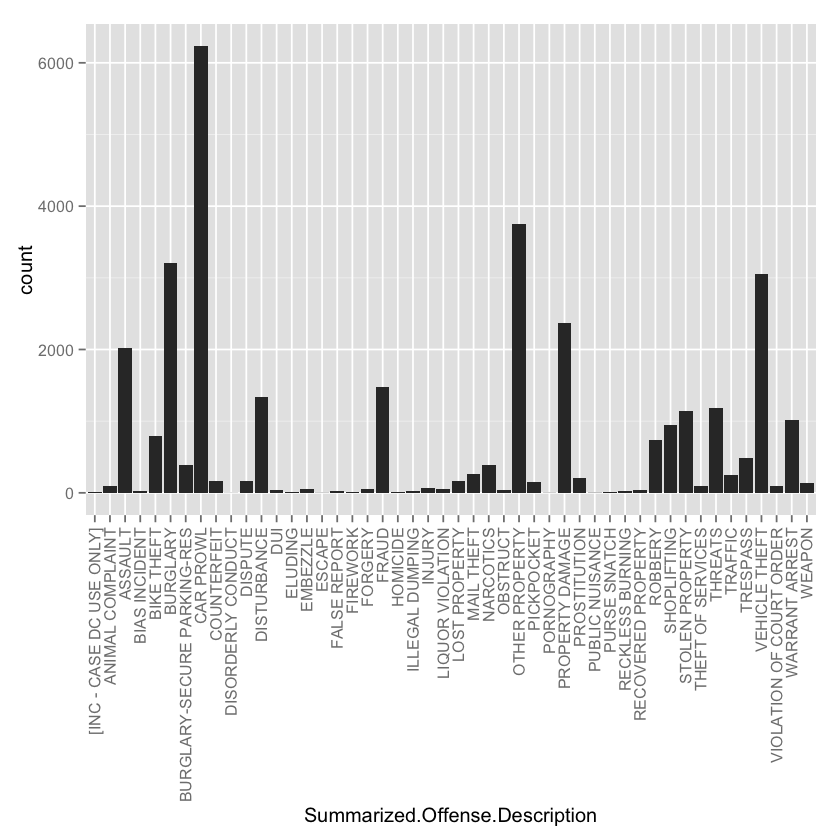

In [251]:
# lets explore how frequently these occur in our sample by examining them visually
library(ggplot2)

# show a histogram of sample data
c <- ggplot(seattle, aes(x = Summarized.Offense.Description)) 
c + geom_histogram() + theme(axis.text.x  = element_text(angle=90, hjust=1, vjust=0.5))


These categories are quite specific. Based on the sample above I am exploring the Summary.Offense.Code which provides a less specific categorization.

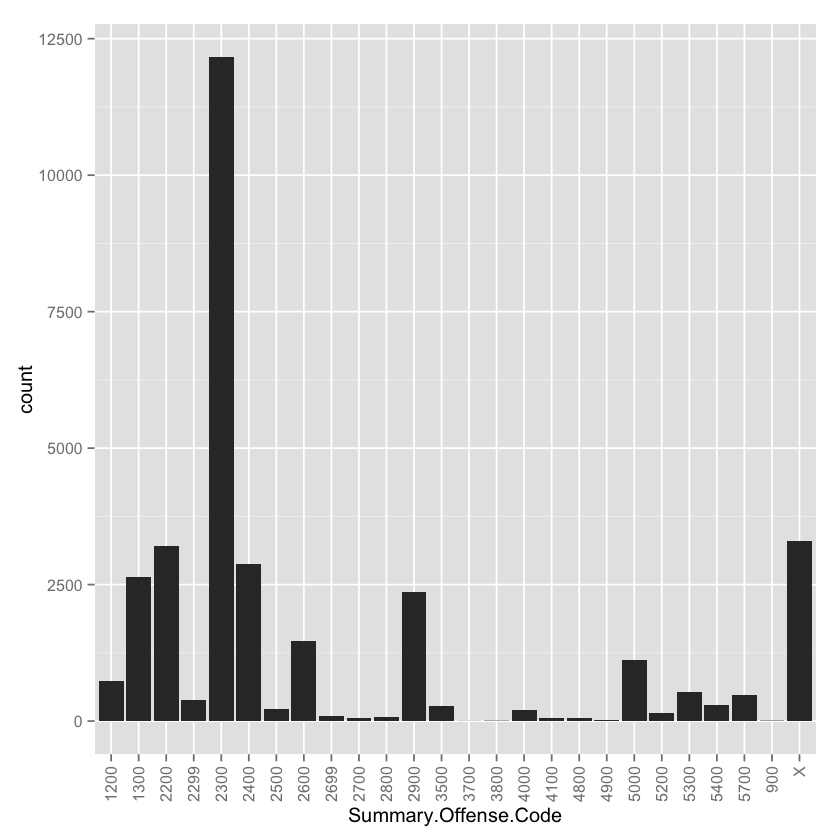

In [252]:
# examining the Summary.Offense.Code which is more general
c <- ggplot(seattle, aes(x = Summary.Offense.Code)) 
c + geom_histogram() + theme(axis.text.x  = element_text(angle=90, hjust=1, vjust=0.5))


The majority of the crimes are categorized with the code '2300'. I propose to examine this specific categorization in more detail, and to explore how this varies by time, and location.

In [253]:
# let's explore what these specific crime codes are
codes <- data.frame(code = seattle$Summary.Offense.Code, description = seattle$Summarized.Offense.Description)

# and reduce these to unique values
codes <- unique(codes)

# focus on a specific type of theft
theft_code <- c('2300')

In [254]:
# focusing just on crime reports that correctly use the theft code 2300
subset(codes, code %in% theft_code)

,code,description
3,2300,MAIL THEFT
5,2300,OTHER PROPERTY
17,2300,CAR PROWL
63,2300,PICKPOCKET
99,2300,BIKE THEFT
472,2300,SHOPLIFTING
744,2300,VEHICLE THEFT
2248,2300,PURSE SNATCH


In [255]:
# now subset Seattle data to use this theft criteria
seattle_theft <- subset(seattle, Summary.Offense.Code %in% theft_code)

In [256]:
# explore these thefts by sector
# a map of sectors is shown here
# http://spdblotter.seattle.gov/2015/01/27/spd-adds-supervisors-shifts-police-beats-as-part-of-reform-efforts/

# first examine how many sectors exist in this data set
unique(seattle_theft$District.Sector)
seattle_theft$count <- 1

# remove incorrect sectors - exclude two that are erroneous and should be recategorized
seattle_theft <- subset(seattle_theft, District.Sector != '')
seattle_theft <- subset(seattle_theft, District.Sector != '99')
unique(seattle_theft$District.Sector)

[1] "F"  "J"  "R"  "Q"  "N"  "B"  "S"  "W"  "D"  "E"  "K"  "L"  "C"  "U"  "G" 
[16] "M"  "O"  ""   "99"

[1] "F" "J" "R" "Q" "N" "B" "S" "W" "D" "E" "K" "L" "C" "U" "G" "M" "O"

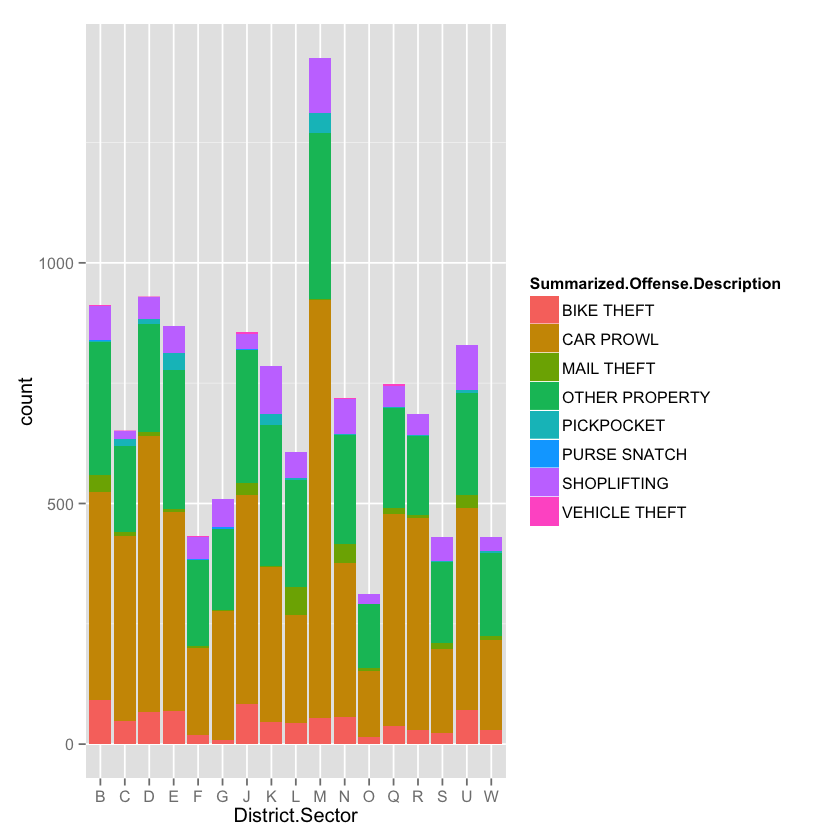

In [257]:
# plot thefts per sector, and color each bar by theft type
ggplot(seattle_theft, aes(District.Sector, fill=Summarized.Offense.Description)) + geom_bar()

In [258]:
# Do thefts vary by time of day? To examine this we are only going to use the 'Occurred.Date.or.Date.Range.Start'. 
# While a theft could take place over time, it seems most interesting to examine when the theft started

# tidy up date / timestamps. Here we can chop out the day as we are just interested in the hour
library(lubridate)

# the date/time is structured as follows
# 06/28/2014 10:31:00 AM
seattle_theft$crime_time <- mdy_hms(seattle_theft$Occurred.Date.or.Date.Range.Start, tz="America/Los_Angeles")

# encode the hour that the crime occurred at
seattle_theft$hour <- hour(seattle_theft$crime_time)

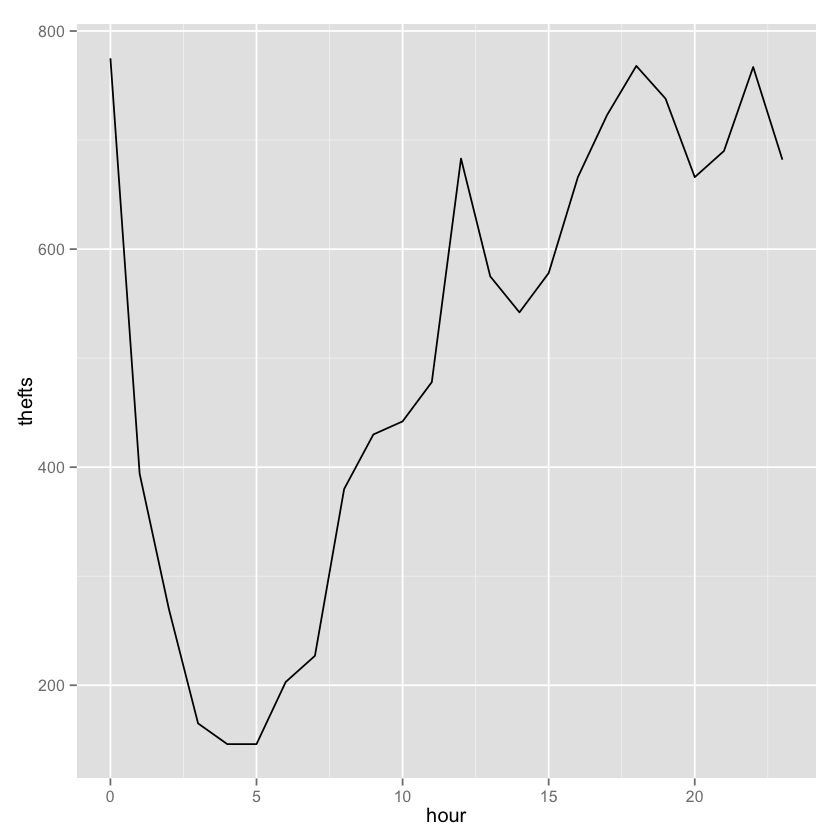

In [259]:
#  explore what the breakdown of these crimes is per sector, and also per time, aggregating all crimes per hour
seattle_theft_hourly <- aggregate(seattle_theft$count, by=list(seattle_theft$hour), FUN=sum)
colnames(seattle_theft_hourly) <- c('hour', 'thefts')
ggplot(seattle_theft_hourly, aes(y=thefts, x=hour)) + geom_line()

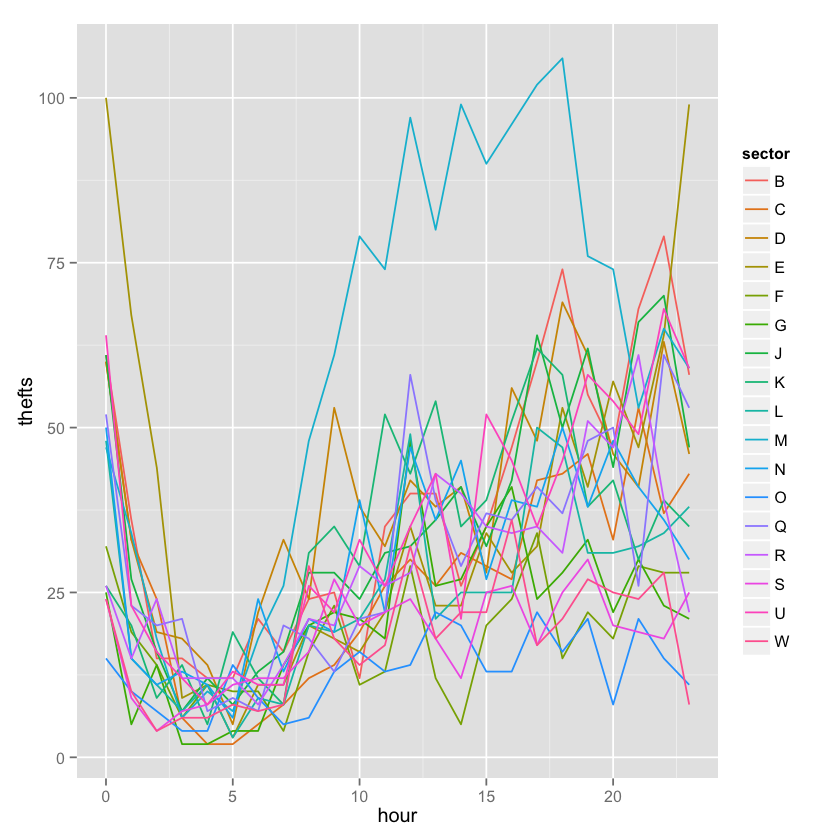

In [260]:
# aggregate thefts per hour and per sector 
seattle_theft_hourly_sector <- aggregate(seattle_theft$count, by=list(seattle_theft$hour, seattle_theft$District.Sector), FUN=sum)
colnames(seattle_theft_hourly_sector) <- c('hour', 'sector', 'thefts')
ggplot(seattle_theft_hourly_sector, aes(y=thefts, x=hour, color=sector)) + geom_line()

It's hard to decipher patterns between individual sectors, but we can see that there is one sector (represented by a blue line) that is behaving very differently compared to all others. Let's plot the data using a different approach to identify that sector.

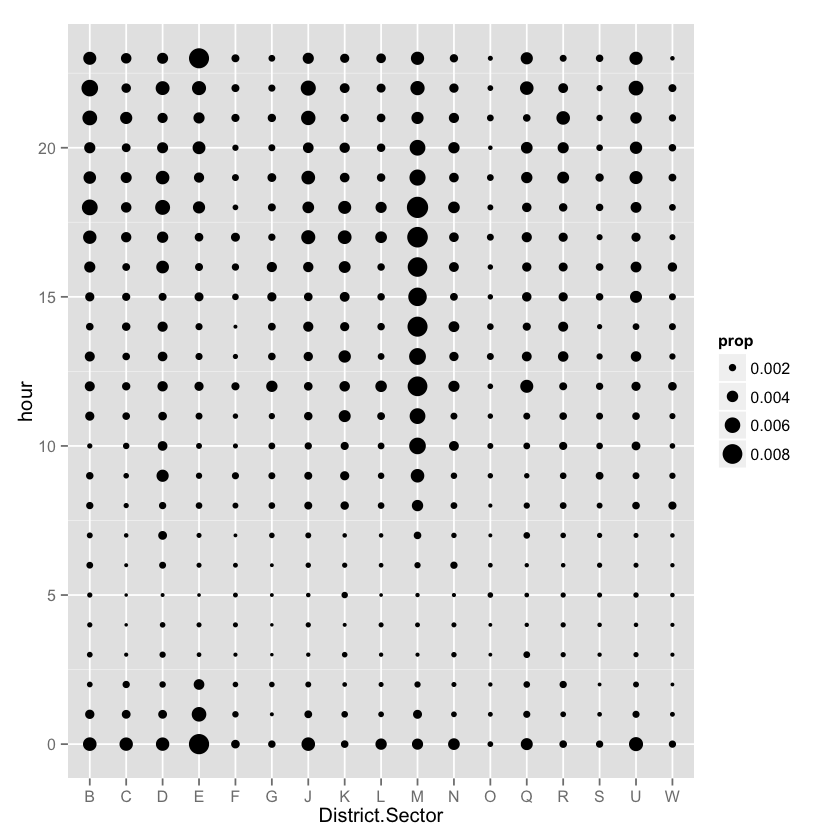

In [261]:
# aggregating data by hour, scale circle size by total proportion of crimes
ggplot(seattle_theft, aes(x=District.Sector, y=hour)) + stat_sum(aes(group=count))

This chart clearly illustrates that Sector M has a distinct pattern of behavior as many crimes are occuring much earlier in the day. We can now see a few time "hotspots" when crimes of theft are more likely to occur. Sector M is an interesting case, as it shows that there are a lot of thefts occuring during the day. 

Finally, let's plot the crimes by each sector, per day, per time

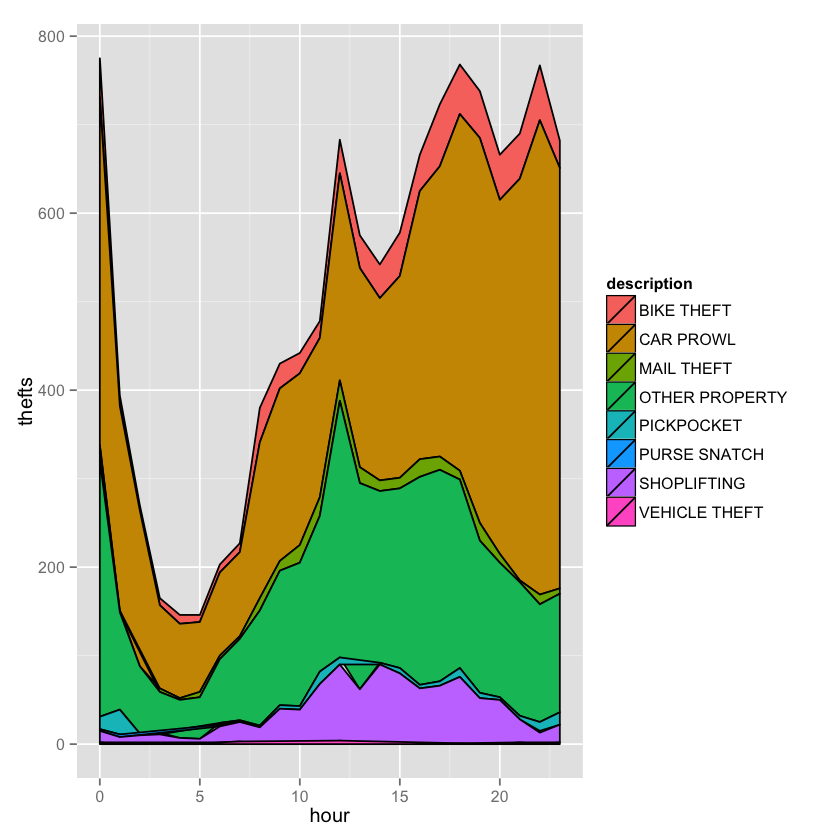

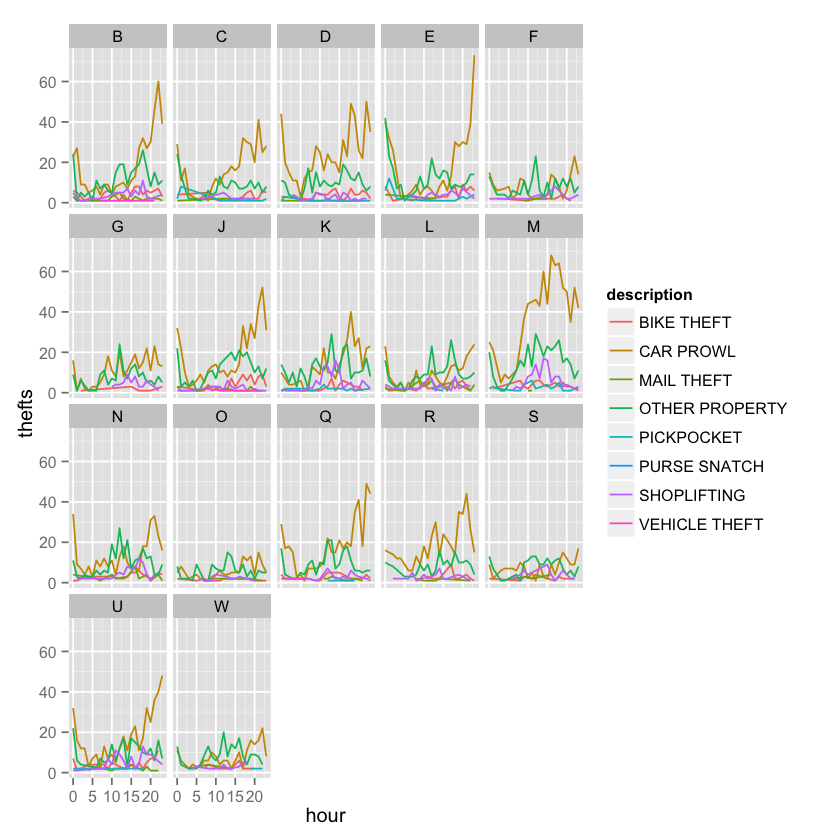

In [272]:
# aggregate thefts per hour and per crime type
seattle_theft_hourly_type <- aggregate(seattle_theft$count, by=list(seattle_theft$hour, seattle_theft$Summarized.Offense.Description), FUN=sum, drop=F)
colnames(seattle_theft_hourly_type) <- c('hour', 'description','thefts')
seattle_theft_hourly_type <- seattle_theft_hourly_type[with(seattle_theft_hourly_type, order(description, thefts, decreasing = T)), ]
ggplot(seattle_theft_hourly_type, aes(y=thefts, x=hour)) + geom_area(aes(colour=description, fill=description), position = 'stack', colour="black")

# aggregate per hour, per sector and per description
seattle_theft_hourly_sector_type <- aggregate(seattle_theft$count, by=list(seattle_theft$hour, seattle_theft$District.Sector, seattle_theft$Summarized.Offense.Description), FUN=sum, drop=F)
colnames(seattle_theft_hourly_sector_type) <- c('hour', 'sector', 'description','thefts')
ggplot(seattle_theft_hourly_sector_type, aes(y=thefts, x=hour)) + geom_line(aes(colour=description)) + facet_wrap(~sector)

We can conclude, there is clear hourly variation in theft rates, which holds true for almost every sector. Between the hours of 4-5 AM the fewest numbers of thefts occurs. Thefts spike later in the day, around 6pm and later at around midnight.